In [3]:
%reset -f
# Gait Quality Score con Autoencoders y Sliding Windows

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from keras.layers import Input, Dense
from keras import regularizers
import matplotlib.pyplot as plt

# === Paso 1: Cargar dataset ===
filePath = './GaitData/gait.csv'
df = pd.read_csv(filePath)

c:\Users\Usuario\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\Usuario\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\Usuario\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/f

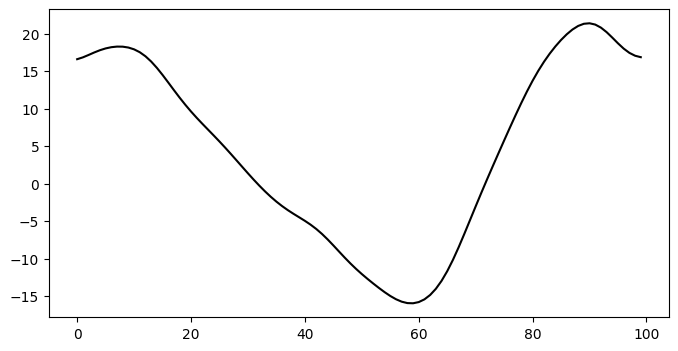

In [5]:
# === Paso 2: Preparar datos de todas las articulaciones ===
joint_map = {1: 'ankle', 2: 'knee', 3: 'hip'}
data_by_joint = {}
scalers = {}
holdout_by_joint = {}  
holdout_subjects =  [9] # sujetos excluidos del entrenamiento

for joint_id, joint_name in joint_map.items():
    df_joint_all = df[(df['joint'] == joint_id) & (df['condition'] == 1)]  # solo marcha normal
    df_train = df_joint_all[~df_joint_all['subject'].isin(holdout_subjects)] # datos de entrenamiento
    df_hold  = df_joint_all[df_joint_all['subject'].isin(holdout_subjects)] # datos de validación

    #MATRIZ DE ENTRENAMIENTO
    grouped = df_train.groupby(['subject', 'replication', 'leg']) # agrupa por sujeto, repetición y pierna
    series_list = [] 
    for _, group in grouped: #crea las series temporales
        series = group.sort_values('time')['angle'].values
        if len(series) >= 100:
            series_list.append(series[:100]) # solo cien puntos
    X = np.stack(series_list) # matriz de series temporales (entrenamiento)

      
    scaler = StandardScaler()
    data_by_joint[joint_name] = X
    scalers[joint_name] = scaler
    

plt.figure(figsize=(8, 4))
plt.plot(X[0], color='black') # gráfico de prueba (primera serie del último conjunto procesado)


In [8]:
# === Paso 3: Entrenar autoencoders por articulación ===
from keras.callbacks import EarlyStopping 
models = {}

for joint_name, X in data_by_joint.items():
    input_dim = X.shape[1]
    
    # Se establece la arquitectura del autoencoder
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(64, activation='relu')(input_layer)
    encoded = Dense(32, activation='relu')(encoded)
    encoded = Dense(16, activation='relu', activity_regularizer=regularizers.l1(1e-5))(encoded)
    
    decoded = Dense(32, activation='relu')(encoded)
    decoded = Dense(64, activation='relu')(decoded)
    decoded = Dense(input_dim, activation='linear')(decoded)
    
    # Compilar y entrenar el modelo
    model = Model(inputs=input_layer, outputs=decoded)
    model.compile(optimizer='adam', loss='mse')
    early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    model.fit(X, X,     # entrenar para reconstruir la entrada (X-X)
          epochs=100,
          batch_size=16,
          shuffle=True,
          verbose=1,
          callbacks=[early_stop])
    
    # Guarda el modelo entrenado
    models[joint_name] = model

# Calcular errores y definir umbral realista (media + 3*std)
error_distributions = {}

for joint_name, X in data_by_joint.items(): # por cada matriz de articulación
    model = models[joint_name]
    recon = model.predict(X, verbose=0) # reconstrucción
    errors = np.mean((X - recon) ** 2, axis=1) # se calcula el error cuadrático medio por serie
    
    err_min = float(np.percentile(errors, 0.5))     # más robusto que min()
    err_max = float(np.percentile(errors, 99.5))    # ignora outliers

    error_distributions[joint_name] = {
        "min": err_min,
        "max": err_max,
        "mean": float(np.mean(errors)),
        "std": float(np.std(errors))
    }

    print('Err {}'.format(joint_name),error_distributions[joint_name])

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 68.0929  
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 42.6329 
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.3764 
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.3743 
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.5984  
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.6356 
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.8155 
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.0463 
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1764 
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3242 
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5493 
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9505 
Epoch 13/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4526 
Epoch 14/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0967 
Epoch 15/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

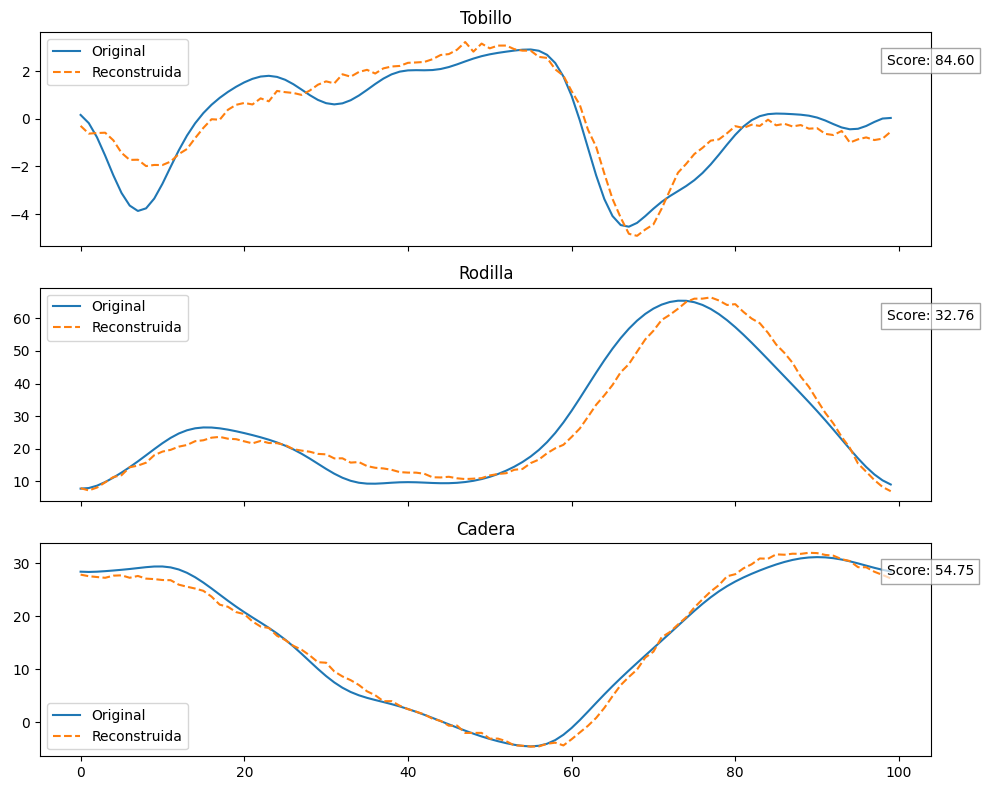

In [142]:
# === Paso 4: Evaluar señal con score normalizado ===
import random
subject_id = random.randint(6,6) # selección de sujeto
df_test = pd.read_csv(filePath)
leg_id = random.randint(2,2) # selección de pierna
condition_id = random.randint(3,3) # selección de condición 
replication_id = 10 #random.randint(2,2) # selección de repetición
joint_scores = {}

scores = []
originalSignals = []
reconSignals = []
scoreStrings = []

for joint_id, joint_name in joint_map.items():
    df_joint = df_test[(df_test['joint'] == joint_id) & # datos de articulación
                       (df_test['condition'] == condition_id) & # para esta condición
                       (df_test['subject'] == subject_id) & # este sujeto
                       (df_test['leg'] == leg_id) & # esta pierna
                       (df_test['replication'] == replication_id)] # y esta repetición
    signal = df_joint.sort_values('time')['angle'].values[:100] # solo cien puntos
    model = models[joint_name]
    
    originalSignals.append(signal)
    signal = signal.reshape(1, -1)
    recon = model.predict(signal, verbose=0)
    reconSignals.append(recon[0])

    # Error y score normalizado
    error = np.mean((signal[0] - recon[0]) ** 2)
    err_min = error_distributions[joint_name]['min']
    err_max = error_distributions[joint_name]['max']
    log_error = np.log1p(error)
    log_err_min = np.log1p(err_min)
    log_err_max = np.log1p(6*err_max)

    score = 100 * (1 - (log_error - log_err_min) / (log_err_max - log_err_min))
    score = np.clip(score, 0, 100)

    scores.append(score)
    joint_scores[joint_name] = score
    scoreStrings.append(f"Score: {score:.2f}")

# === Gráfica ===
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
titles = ['Tobillo', 'Rodilla', 'Cadera']

for i in range(3):
    axs[i].plot(originalSignals[i], label='Original')
    axs[i].plot(reconSignals[i], label='Reconstruida', linestyle='--')
    axs[i].set_title(titles[i])
    axs[i].legend()
    axs[i].text(0.95, 0.9,
                scoreStrings[i],
                transform=axs[i].transAxes,
                ha='left', va='top',
                fontsize=10,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

plt.tight_layout()
plt.show()


In [ ]:
# === Paso 5: Sistema de clasificación simple ===

ScoreA = scores[0]
ScoreK = scores[1]
ScoreH = scores[2]
meanScore = np.mean(scores)

print(f"Score Tobillo: {ScoreA:.2f}")
print(f"Score Rodilla: {ScoreK:.2f}")
print(f"Score Cadera: {ScoreH:.2f}")
print(f"Score Medio : {meanScore:.2f}")

if meanScore >= 75:
    classification = "Usuario con marcha normativa"
elif meanScore >= 50:
    classification = "Usuario con marcha pseudo-normativa"
elif meanScore >= 25:
    classification = "Usuario con marcha levemente alterada" 
else:
    classification = "Usuario con marcha severamente alterada"

type = ''
affected = []
if ScoreA < 40:
    type += 'I'
    affected.append('tobillo')
if ScoreK < 40:
    type += 'I'
    affected.append('rodilla')
if ScoreH < 40:
    type += 'I'
    affected.append('cadera')

classification += f", deficiencia de tipo {type} en {', '.join(affected)}" if type else ''
print("Clasificación:", classification)
print('Sujeto', subject_id, '\tPierna', leg_id, '\tCondición', condition_id, '\tRepetición', replication_id)

Score Tobillo: 84.60
Score Rodilla: 32.76
Score Cadera: 54.75
Score Medio : 57.37
Clasificación: Usuario con marcha levemente alterada, deficiencia de tipo I en rodilla
Sujeto 6 	Pierna 2 	Condición 3 	Repetición 10
